### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 
- As much as possible, try and stick to the hints and functions we import at the top of the homework, as those are the ideas and tools the class supports and is aiming to teach. And if a problem specifies a particular library you're required to use that library, and possibly others from the import list.

Names of people you have worked with goes here: 

<hr style="height:2pt">

![bike_sharing](fig/BSS.png)

<div class="theme">  Main Theme: Multiple Linear Regression, Subset Selection, Polynomial Regression </div>
### Overview 

You are hired by the administrators of the [Capital Bikeshare program](https://www.capitalbikeshare.com) program in Washington D.C., to **help them predict the hourly demand for rental bikes** and **give them suggestions on how to increase their revenue**. Your task is to prepare a short report summarizing your findings and make recommendations.

The predicted hourly demand could be used for planning the number of bikes that need to be available in the system at any given hour of the day. It costs the program money if bike stations are full and bikes cannot be returned, or empty and there are no bikes available. You will use multiple linear regression and polynomial regression and will explore techniques for subset selection to predict bike usage. The goal is to build a regression model that can predict the total number of bike rentals in a given hour of the day, based on all available information given to you. 

An example of a suggestion to increase revenue might be to offer discounts during certain times of the day either during holidays or non-holidays. Your suggestions will depend on your observations of the seasonality of ridership.

The data for this problem were collected from the Capital Bikeshare program over the course of two years (2011 and 2012).


### Use only the libraries below:

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from pandas.plotting import scatter_matrix

import seaborn as sns


%matplotlib inline

## Data Exploration & Preprocessing, Multiple Linear Regression, Subset Selection


### Overview
The initial data set is provided in the file `data/BSS_hour_raw.csv`. You will first add features that will help with the analysis and then separate the data into training and test sets. Each row in this file represents the number of rides by registered users and casual users in a given hour of a specific date. There are 12 attributes in total describing besides the number of users the weather if it is a holiday or not etc: 


- `dteday` (date in the format YYYY-MM-DD, e.g. 2011-01-01)
- `season` (1 = winter, 2 = spring, 3 = summer, 4 = fall)
- `hour` (0 for 12 midnight, 1 for 1:00am, 23 for 11:00pm)
- `weekday` (0 through 6, with 0 denoting Sunday)
- `holiday` (1 = the day is a holiday, 0 = otherwise)
- `weather`
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm
    - 4: Heavy Rain + Thunderstorm + Mist, Snow + Fog 
- `temp` (temperature in Celsius)
- `atemp` (apparent temperature, or relative outdoor temperature, in Celsius)
- `hum` (relative humidity)
- `windspeed` (wind speed)
- `casual` (number of rides that day made by casual riders, not registered in the system)
- `registered` (number of rides that day made by registered riders)

### General Hints
- Use pandas .describe() to see statistics for the dataset.
- When performing manipulations on column data it is useful and often more efficient to write a function and apply this function to the column as a whole without the need for iterating through the elements.
- A scatterplot matrix or correlation matrix are both good ways to see dependencies between multiple variables.
- For Question 2, a very useful pandas method is .groupby(). Make sure you aggregate the rest of the columns in a meaningful way. Print the dataframe to make sure all variables/columns are there!

### Resources 
http://pandas.pydata.org/pandas-docs/stable/generated/pandas.to_datetime.html

<div class="exercise"> <b> Question 1 [10pts]: Data Read-In and Cleaning </b> </div>

In this section, we read in the data and begin one of the most important analytic steps: verifying that the data is what it claims to be.

**1.1** Load the dataset from the csv file `data/BSS_hour_raw.csv` into a pandas dataframe that you name `bikes_df`. Do any of the variables' ranges or averages seem suspect? Do the data types make sense?

**1.2** Notice that the variable in column `dteday` is a pandas `object`, which is **not**  useful when you want to extract the elements of the date such as the year, month, and day. Convert `dteday` into a `datetime` object to prepare it for later analysis.

**1.3** Create three new columns in the dataframe:
- `year` with 0 for 2011, 1 for 2012, etc.
- `month` with 1 through 12, with 1 denoting January.
- `counts` with the total number of bike rentals for that **hour** (this is the response variable for later).

### Answers

#### **1.1** Load the dataset from the csv file `data/BSS_hour_raw.csv` into a pandas dataframe that you name `bikes_df`. Do any of the variables' ranges or averages seem suspect? Do the data types make sense?

In [3]:
# your code here
bikes_df = pd.read_csv('data/BSS_hour_raw.csv')
print(bikes_df.info())
bikes_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 13 columns):
dteday        17379 non-null object
season        17379 non-null int64
hour          17379 non-null int64
holiday       17379 non-null int64
weekday       17379 non-null int64
workingday    17379 non-null int64
weather       17379 non-null int64
temp          17379 non-null float64
atemp         17379 non-null float64
hum           17379 non-null float64
windspeed     17379 non-null float64
casual        17379 non-null int64
registered    17379 non-null int64
dtypes: float64(4), int64(8), object(1)
memory usage: 1.7+ MB
None


,dteday,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered
0,2011-01-01,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13
1,2011-01-01,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32
2,2011-01-01,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27
3,2011-01-01,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10
4,2011-01-01,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1


In [4]:
# your code here
bikes_df.describe()

,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,2.501640,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869
std,1.106918,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000
50%,3.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000
75%,3.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000
max,4.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000


In [5]:
# your code here
bikes_df.dtypes

dteday         object
season          int64
hour            int64
holiday         int64
weekday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
dtype: object

*Your answer here*

The temperature(`temp`), average temperature (`atemp`)	humidity (`hum`), and windspeed (`winspeed`) variables seem to have been normalized to range from 0 to 1. If not, for instance, DC would see high of 1 degrees and a low of 0.2 degrees farenheight.

All data types make sense for the data stored, except dteday, which is an object.


#### **1.2** Notice that the variable in column `dteday` is a pandas `object`, which is **not**  useful when you want to extract the elements of the date such as the year, month, and day. Convert `dteday` into a `datetime` object to prepare it for later analysis.

In [6]:
# your code here
bikes_df['dteday'] = pd.to_datetime(bikes_df['dteday'])
bikes_df.dtypes

dteday        datetime64[ns]
season                 int64
hour                   int64
holiday                int64
weekday                int64
workingday             int64
weather                int64
temp                 float64
atemp                float64
hum                  float64
windspeed            float64
casual                 int64
registered             int64
dtype: object

#### **1.3** Create three new columns in the dataframe:
- `year` with 0 for 2011, 1 for 2012, etc.
- `month` with 1 through 12, with 1 denoting January.
- `counts` with the total number of bike rentals for that hour (this is the response variable for later).

In [7]:
# your code here

# function to assign 0 to 2011 and 1 to 2012
def encode_year(x):
    return np.int64(np.floor(x-2011))
   
    
# create `year` column
bikes_df.loc[:,'year'] = bikes_df.dteday.dt.year

# create `month` column
bikes_df.loc[:,'month'] = bikes_df.dteday.dt.month
   
# encode `year` column with 0 and 1
bikes_df['year'] = bikes_df['year'].apply(encode_year)

bikes_df['counts'] = bikes_df.casual+ bikes_df.registered

# re-organize the columns 
columns = ['dteday','hour','season', 'holiday', 'year','month','weekday', \
           'workingday','weather', 'temp', 'atemp', 'hum', 'windspeed', \
           'casual', 'registered', 'counts']
bikes_df = bikes_df.reindex(columns = columns)

In [8]:
# your code here

bikes_df.head()

,dteday,hour,season,holiday,year,month,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered,counts
0,2011-01-01,0,1,0,0,1,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2011-01-01,1,1,0,0,1,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,2011-01-01,2,1,0,0,1,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,2011-01-01,3,1,0,0,1,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,2011-01-01,4,1,0,0,1,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


<div class='exercise'> <b> Question 2 [20 pts]: Exploratory Data Analysis. </b></div>

In this question, we continue validating the data, and begin hunting for patterns in ridership that shed light on who uses the service and why.

**2.1** Use pandas' `scatter_matrix` command to visualize the inter-dependencies among all predictors in the dataset.  Note and comment on any strongly related variables. [This will take several minutes to run. You may wish to comment it out until your final submission, or only plot a randomly-selected 10% of the rows]

**2.2** Make a plot showing the _average_ number of casual and registered riders during each hour of the day. `.groupby` and `.aggregate` should make this task easy. Comment on the trends you observe. 

**2.3** Use the variable `weather` to show how each weather category affects the relationships in question 2.2.  What do you observe?

**2.4** Make a new dataframe with the following subset of attributes from the previous dataset and with each entry being just **one** day: 

- `dteday`, the timestamp for that day (fine to set to noon or any other time) 
- `weekday`, the day of the week
- `weather`, the most severe weather that day
- `season`, the season that day falls in
- `temp`, the average temperature (normalized)
- `atemp`, the average atemp that day (normalized)
- `windspeed`, the average windspeed that day (normalized)
- `hum`, the average humidity that day (normalized)
- `casual`, the **total** number of rentals by casual users
- `registered`, the **total** number of rentals by registered users
- `counts`, the **total** number of rentals of that day

Name this dataframe `bikes_by_day`.

Make a plot showing  the _distribution_ of the number of casual and registered riders on each day of the week.

**2.5** Use `bikes_by_day` to visualize how the distribution of **total number of rides** per day (casual and registered riders combined) varies with the **season**. Do you see any **outliers**? Here we use the pyplot's boxplot function definition of an outlier as any value 1.5 times the IQR above the 75th percentile or 1.5 times the IQR below the 25th percentiles. If you see any outliers, identify those dates and investigate if they are a chance occurence, an error in the data collection, or a significant event (an online search of those date(s) might help). 



### Answers

#### **2.1** Use pandas' `scatter_matrix` command to visualize the inter-dependencies among all predictors in the dataset.  Note and comment on any strongly related variables. [This will take several minutes to run. You may wish to comment it out until your final submission, or only plot a randomly-selected 10% of the rows]

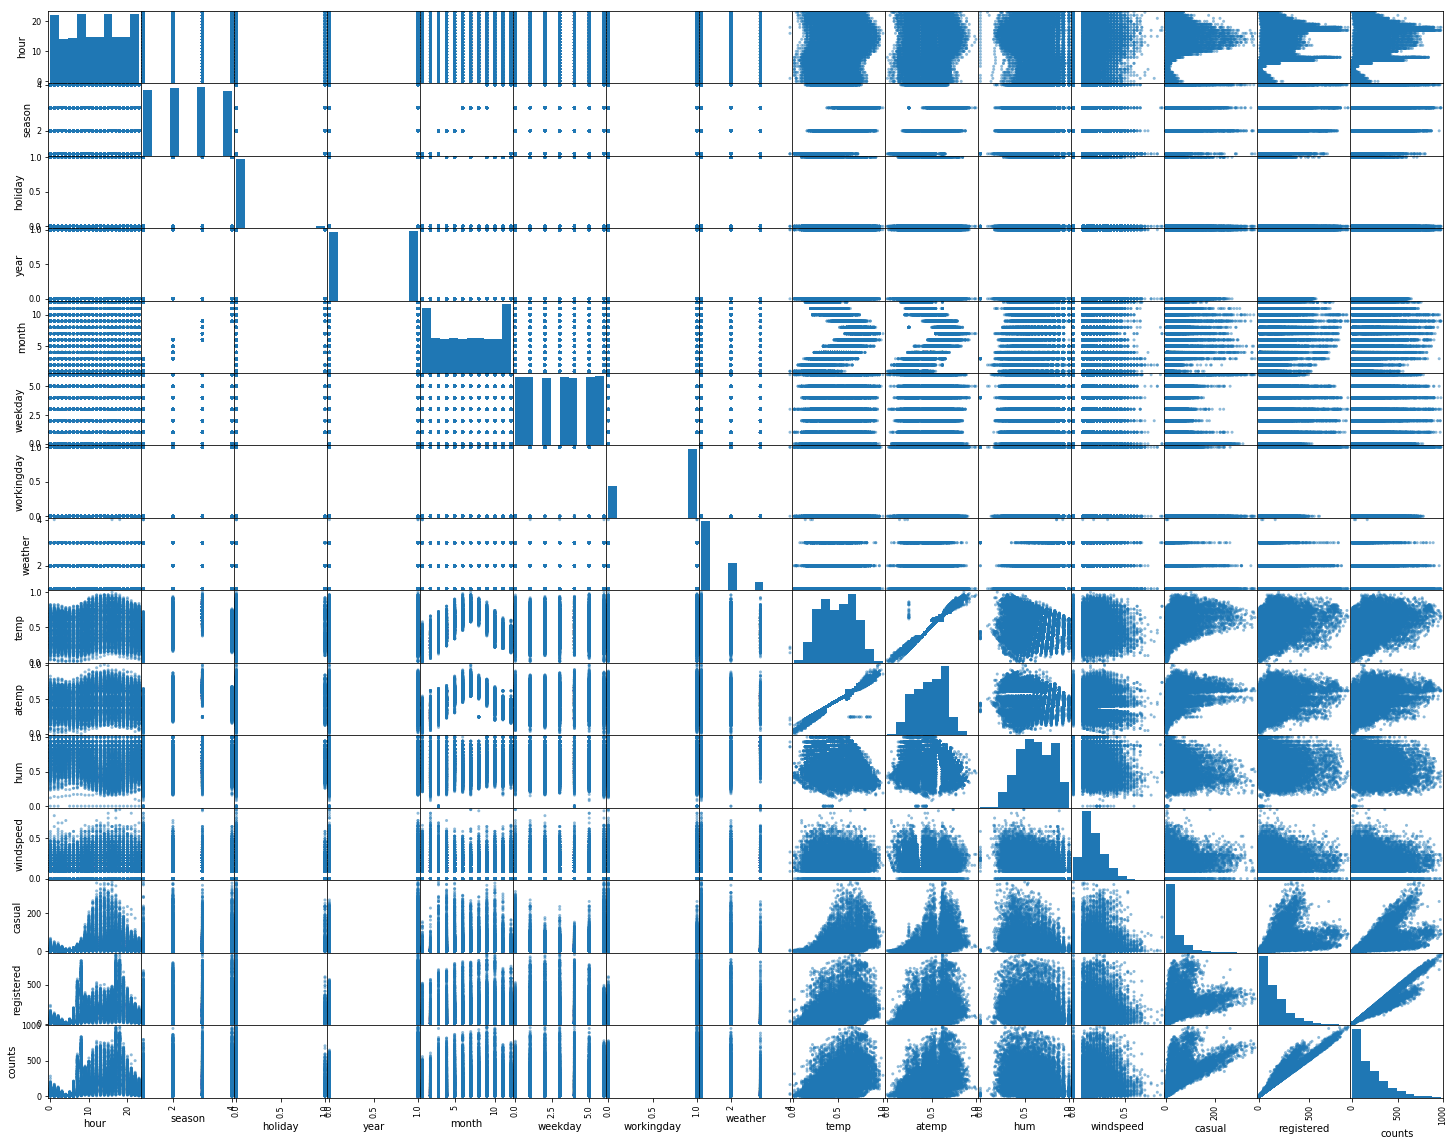

In [9]:
# your code here

# make combinations of features
scatter_matrix(bikes_df, alpha=0.5, figsize=(25,20));


*your answer here* 

Strongly related variables: temp and atemp, registered and counts, casual and counts, casual and registered. Less significant correlation between temp and casual, and atemp and casual.

**2.2** Make a plot showing the _average_ number of casual and registered riders during each hour of the day. `.groupby` and `.aggregate` should make this task easy. Comment on the trends you observe. 

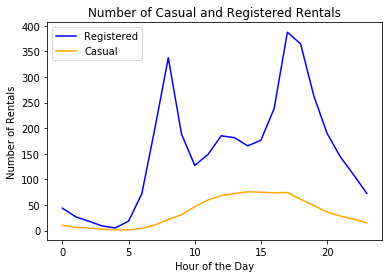

In [10]:
# your code here
reg_color = 'blue'
casual_color = 'orange'

mean_data = bikes_df.groupby('hour').aggregate({'casual': np.mean, 'registered': np.mean})

num_days = mean_data.shape[0]
plt.plot(np.arange(num_days), mean_data['registered'], color = reg_color, label="Registered")
plt.plot(np.arange(num_days), mean_data['casual'], color = casual_color, label="Casual")

plt.xlabel("Hour of the Day")
plt.ylabel("Number of Rentals")
plt.title("Number of Casual and Registered Rentals")
plt.legend();

*your answer here*

Trends: It appears that the number of registered users is higher than the number of casual users at peak hours of the day (i.e. rush hour at 8am and 5pm, approximately). There is more fluctuation in the number of registered users throughout the day than in the number of casual users.

#### **2.3** Use the variable `weather` to show how each weather category affects the relationships in question 2.2.  What do you observe?

In [11]:
# your code here

days_tick_dict = {0: 'Sunday', 1: 'Monday', 2: 'Tuesday', 3: 'Wednesday',
                 4: 'Thursday', 5: 'Friday', 6: 'Saturday'}  

hours_tick_dict = {k:v for k,v in zip(range(24),range(24))}
def get_violin_lists(bikes_data, colname):
    """Helper function for building violin plots."""
    
    # prepare the lists
    reg_data = []
    cas_data = []
    
    # at each day, record ALL values of 'rigistered' and 'casual' observed    
    for cur_val, cur_df in bikes_data.groupby(colname):
        cur_registered = cur_df['registered'].copy().values.reshape(-1,1)
        cur_casual = cur_df['casual'].copy().values.reshape(-1,1)

        reg_data.append(cur_registered)
        cas_data.append(cur_casual)
    
    # return the lists
    return reg_data,cas_data


# color the registered users orange
def color_violin(violin_result, color_string):
    """Helper to color a violin plot"""
  
    # color the distribution
    for pc in violin_result['bodies']:
        pc.set_color(color_string)

    # color the lines
    for partname in ('cbars','cmins','cmaxes'):
        vp = violin_result[partname]
        vp.set_edgecolor(color_string)

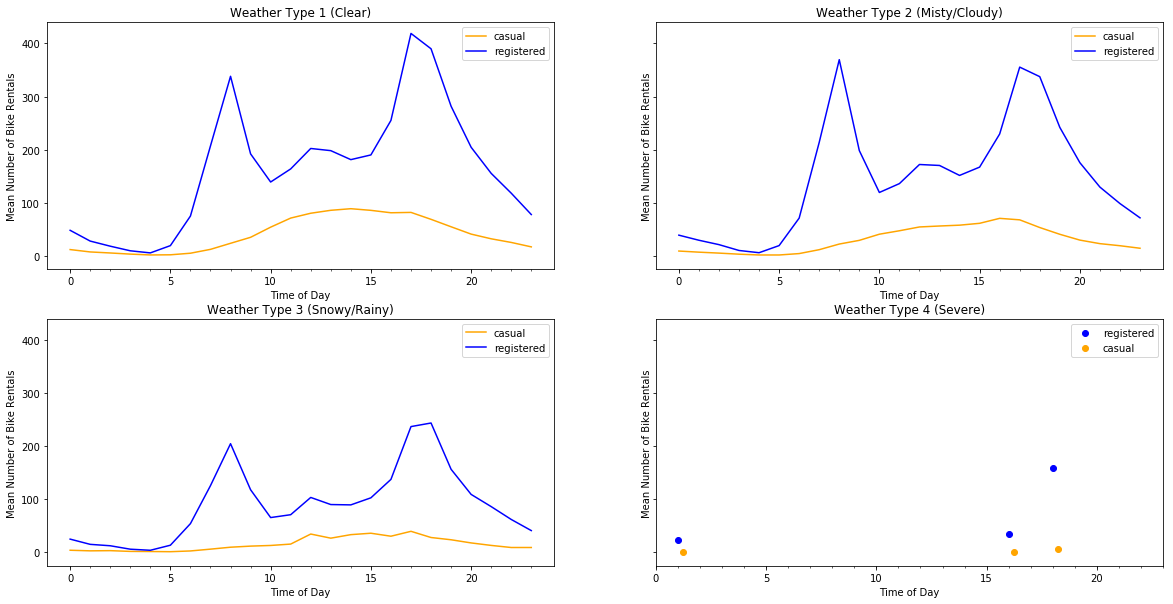

In [12]:
# your code here

fig, ax = plt.subplots(2,2, figsize=(20,10), sharey=True)
ax = ax.ravel()

weather_strings = ["Clear", "Misty/Cloudy", "Snowy/Rainy", "Severe"]
for cur_weather in range(1,5):
    cur_ax = ax[cur_weather-1]
    cur_weather_string = weather_strings[cur_weather-1]
    
    bikes_df_weather = bikes_df[(bikes_df.weather == cur_weather)]
    
    
    if cur_weather == 4:
        # for blizard weather we have maximum one data point per hour, and often none
        # just scatter plot the data
        reg = cur_ax.scatter(bikes_df_weather['hour'].values, bikes_df_weather['registered'].values, color = reg_color, label="registered")
        cas = cur_ax.scatter(bikes_df_weather['hour'].values+.25, bikes_df_weather['casual'].values, color = casual_color, label="casual")
    else:
        #for most weathers, we just plot the mean at each hour
        mean_data = bikes_df_weather.groupby('hour').aggregate({'casual': np.mean, 'registered': np.mean})
        # mean lines
        reg_hourly_data_mean= mean_data['registered']
        cas_hourly_data_mean= mean_data['casual']
        
        cur_ax.plot(cas_hourly_data_mean, casual_color, label="casual")
        cur_ax.plot(reg_hourly_data_mean, reg_color, label="registered")
        
    cur_ax.legend()
    
    cur_ax.set_xticks(list(hours_tick_dict.keys()), list(hours_tick_dict.values()))
    cur_ax.set_ylabel('Mean Number of Bike Rentals')
    cur_ax.set_xlabel('Time of Day')
    cur_ax.set_title('Weather Type {} ({})'.format(cur_weather, cur_weather_string))

*your answer here*

It seems that the weather does not have a significant impact on the number of riders (both casual and registered) which is contraintuitive. However, in the severe weather conditions, almost no rides take place as one would expect.  Note: the violin plots were not expected (only the line grphs in each subplot would suffice), but they definitely add to the story.


#### **2.4** Make a new dataframe with the following subset of attributes from the previous dataset and with each entry being just **one** day: 

- `dteday`, the timestamp for that day (fine to set to noon or any other time) 
- `weekday`, the day of the week
- `weather`, the most severe weather that day
- `season`, the season that day falls in
- `temp`, the average temperature (normalized)
- `atemp`, the average atemp that day (normalized)
- `windspeed`, the average windspeed that day (normalized)
- `hum`, the average humidity that day (normalized)
- `casual`, the **total** number of rentals by casual users
- `registered`, the **total** number of rentals by registered users
- `counts`, the **total** number of rentals of that day

#### Name this dataframe `bikes_by_day`.

#### Make a plot showing  the _distribution_ of the number of casual and registered riders on each day of the week.

In [14]:
# your code here

bikes_by_day = bikes_df.copy()
# for scatterplot of season against counts first we need to group by day and 
# aggregate counts
bikes_by_day = bikes_by_day[['dteday', 'weather', 
                             'season', 'windspeed', 'temp', 'atemp', 
                             'hum', 
                             'weekday', 'casual', 'registered', 
                             'counts']].groupby('dteday').agg({'counts' : np.sum,
                                                                'casual' : np.sum,
                                                                'weather': np.max,
                                                                'registered' : np.sum,
                                                                'season' : np.mean,
                                                                'weekday' : np.mean,
                                                                'windspeed': np.mean,
                                                                'temp' : np.mean,
                                                                'atemp' : np.mean,
                                                                'hum' : np.mean})
bikes_by_day.head(5)

,counts,casual,weather,registered,season,weekday,windspeed,temp,atemp,hum
dteday,,,,,,,,,,
2011-01-01,985,331,3,654,1,6,0.160446,0.344167,0.363625,0.805833
2011-01-02,801,131,3,670,1,0,0.248539,0.363478,0.353739,0.696087
2011-01-03,1349,120,1,1229,1,1,0.248309,0.196364,0.189405,0.437273
2011-01-04,1562,108,2,1454,1,2,0.160296,0.200000,0.212122,0.590435
2011-01-05,1600,82,1,1518,1,3,0.186900,0.226957,0.229270,0.436957


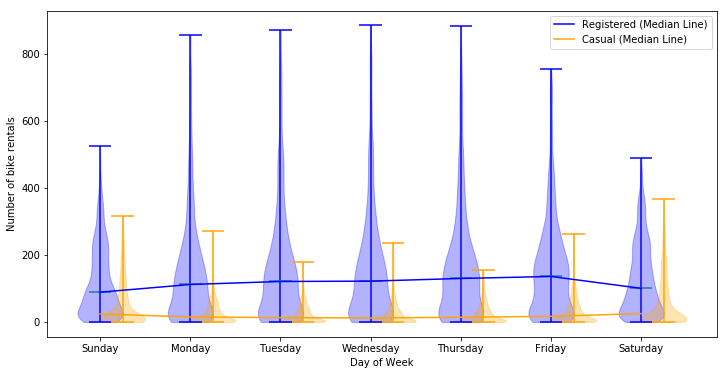

In [24]:
# your code here

# get data for the violin plot
reg_data,cas_data = get_violin_lists(bikes_df, 'weekday')

# plot the violins
plt.figure(figsize=(12,6))
plt.xticks(list(days_tick_dict.keys()), list(days_tick_dict.values()))
position_array = np.arange(len(reg_data))
reg = plt.violinplot(dataset=reg_data, positions=position_array, showmedians=True, showextrema=True)
cas = plt.violinplot(dataset=cas_data, positions=position_array+.25)

# color the violins
color_violin(reg, reg_color)
color_violin(cas, casual_color)

# calculate the median number of registered/casual riders on each weekday
mids = bikes_df.groupby("weekday").median()[["registered","casual"]]

# plot a line connecting the medians of each ditribution
med = plt.plot(position_array, mids["registered"].values,c = reg_color, label="Registered (Median Line)")
medb = plt.plot(position_array, mids["casual"].values,c=casual_color, label="Casual (Median Line)")

# labels
plt.ylabel('Number of bike rentals')
plt.xlabel('Day of Week')
plt.legend()

plt.show()

*your answer here*

Registered: We can see that there is clearly more rides during weekdays than on the weekends. We can hypothesize that registered riders use the bikes to ride to work.
Casual: On the flip side, the casual riders are clearly utilizing the bikes more on the weekends, perhaps for casually riding around the city and less so for work commute.  Note: boxplot would more than suffice to answer this question.


#### **2.5** Use `bikes_by_day` to visualize how the distribution of **total number of rides** per day (casual and registered riders combined) varies with the **season**. Do you see any **outliers**? Here we use the pyplot's boxplot function definition of an outlier as any value 1.5 times the IQR above the 75th percentile or 1.5 times the IQR below the 25th percentiles. If you see any outliers, identify those dates and investigate if they are a chance occurence, an error in the data collection, or a significant event (an online search of those date(s) might help). 

In [16]:
# your code here 
data = [sorted(np.random.normal(0, std, 100)) for std in range(1, 5)]


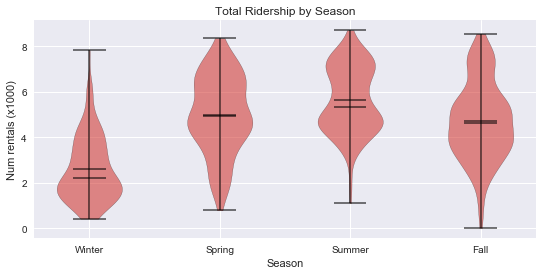

In [17]:
# your code here

# make a figure with two plots
fig, ax1 = plt.subplots(figsize=(9, 4), sharey=True)

for i in range(1,5):
    parts = ax1.violinplot(bikes_by_day.loc[bikes_by_day.season==i,'counts']/1000, positions=[i], 
                  showmeans=True, showmedians=True, showextrema=True)
    for pc in parts['bodies']:
        pc.set_facecolor('#D43F3A')
        pc.set_edgecolor('black')
        pc.set_alpha(.6)
        
    # color the lines
    for partname in ('cbars','cmins','cmaxes', 'cmedians', 'cmeans'):
        vp = parts[partname]
        vp.set_edgecolor('black')
        vp.set_alpha(0.6)


    
    
labels = ["Winter", "Spring", "Summer", "Fall"]
ax1.set_title('Total Ridership by Season')
ax1.set_xlabel("Season")
ax1.set_xticks(np.arange(1, 5))
ax1.set_xticklabels(labels)
ax1.set_ylabel("Num rentals (x1000)");

Or, more simply:

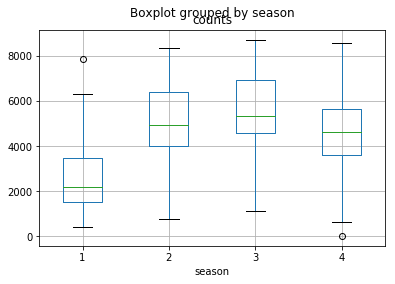

In [16]:
bikes_by_day.boxplot('counts',by='season');

In [85]:
# your code here

# find outlier of variable var_of_interest for season s
def find_outlier(s, var_of_interest, data):
    #print(s)
    pass
    season_df = data[data.season == s]
    
    raw_data = season_df.loc[:,var_of_interest]
    q1 = np.percentile(raw_data,25)
    q3 = np.percentile(raw_data,75)
    IQR = q3 - q1
    
    #print(q1, IQR)
    upper_bound = q3 + 1.5*IQR 
    lower_bound = q1 - 1.5*IQR 
    
    outliers_flag = np.logical_or(raw_data>upper_bound, raw_data<lower_bound)
    
    if np.sum(outliers_flag) == 0:
        print ('no outliers found')
        return None
    else:
        print(np.sum(outliers_flag),"outlier(s) found")
        return season_df.loc[outliers_flag]
    

In [86]:
# your code here 

df = pd.DataFrame(columns = bikes_by_day.columns)

# find outliers in each season
for cur_season in [1,2,3,4]:
    print("Season {}".format(cur_season))
    df = df.append(find_outlier(cur_season, 'counts', bikes_by_day))

df

Season 1
1 outlier(s) found
Season 2
no outliers found
Season 3
no outliers found
Season 4
1 outlier(s) found


,counts,casual,weather,registered,season,weekday,windspeed,temp,atemp,hum
2012-03-17,7836,3155,2,4681,1,6,0.110704,0.514167,0.505046,0.755833
2012-10-29,22,2,3,20,4,1,0.358200,0.440000,0.439400,0.880000


*your answer here* 



We see that the total number of rentals tends to be smaller in the winter (season 1) which makes sense. It then increases in spring, peaks in summer and starts falling again in fall but not as much as in winter.

We observe that March 17, 2012 that is much higher that the others. This is our only high outlier.  It was **St. Patrick's Day** on 2012/3/17! So we concur that this is a real observation (lots of partying!).

And Oct-29-2012, a quick search reveals it was **hurricane Sandy** hitting Washington, DC. Thus, we concur this is a real observation as well (not safe to be biking around that day). 

<HR>

<div class='exercise'> <b> Question 3 [10pts]: Prepare the data for Regression </b> </div>

In order to build and evaluate our regression models, a little data cleaning is needed.  In this problem, we will explicitly create binary variables to represent the categorical predictors, set up the train-test split in a careful way, remove ancillary variables, and do a little data exploration that will be useful to consider in the regression models later.

**3.1** Using `bikes_df`, with hourly data about rentals, convert the categorical attributes ('season', 'month', 'weekday', 'weather') into multiple binary attributes using **one-hot encoding**.

**3.2** Split the updated `bikes_df` dataset in a train and test part. Do this in a 'stratified' fashion, ensuring that all months are equally represented in each set. Explain your choice for a splitting algorithm. 

**3.3** Although we asked you to create your train and test set, but for consistency and easy checking, we ask that for the rest of this problem set you use the train and test set provided in the he files `data/BSS_train.csv` and `data/BSS_test.csv`. Read these two files into dataframes `BSS_train` and `BSS_test`, respectively. Remove the `dteday` column from both the train and the test dataset (its format cannot be used for analysis). Also, remove any predictors that would make predicting the `count` trivial. Note we gave more meaningful names to the one-hot encoded variables.



#### Answers

#### **3.1** Using `bikes_df`, with hourly data about rentals, convert the categorical attributes ('season', 'month', 'weekday', 'weather') into multiple binary attributes using **one-hot encoding**.

In [21]:
# your code here
#save the pre-recoding bikes data
bikes_df_raw = bikes_df.copy(deep=True)
bikes_df.head()

,dteday,hour,season,holiday,year,month,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered,counts
0,2011-01-01,0,1,0,0,1,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2011-01-01,1,1,0,0,1,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,2011-01-01,2,1,0,0,1,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,2011-01-01,3,1,0,0,1,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,2011-01-01,4,1,0,0,1,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [22]:
#your code here
categorical_columns = ['season', 'month', 'holiday', 'weekday', 'workingday', 'weather']
categorical_columns_g2cols = ['season', 'month', 'weekday', 'weather']
numerical_columns = ['temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'counts']

bikes_df = pd.get_dummies(bikes_df_raw, columns=categorical_columns_g2cols, drop_first=True)

In [23]:
#your code here
bikes_df.columns

Index(['dteday', 'hour', 'holiday', 'year', 'workingday', 'temp', 'atemp',
       'hum', 'windspeed', 'casual', 'registered', 'counts', 'season_2',
       'season_3', 'season_4', 'month_2', 'month_3', 'month_4', 'month_5',
       'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11',
       'month_12', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4',
       'weekday_5', 'weekday_6', 'weather_2', 'weather_3', 'weather_4'],
      dtype='object')

In [24]:
#your code here
# give more meaningful names to the one-hot encoded variables
seasons = {'season_2': 'spring', 'season_3': 'summer', 'season_4': 'fall',}
months = {'month_2': 'Feb', 'month_3': 'Mar', 'month_4': 'Apr',
       'month_5':'May', 'month_6': 'Jun', 'month_7': 'Jul', 'month_8': 'Aug', 'month_9': 'Sept', 'month_10': 'Oct',
       'month_11': 'Nov', 'month_12': 'Dec', }
weekdays = {'weekday_1': 'Mon', 'weekday_2': 'Tue', 'weekday_3': 'Wed',
       'weekday_4': 'Thu', 'weekday_5': 'Fri', 'weekday_6': 'Sat'}
weather = {'weather_2': 'Cloudy', 'weather_3': 'Snow', 'weather_4': 'Storm'}

combined_renamer = {**seasons, **months, **weekdays, **weather}

In [25]:
#your code here
bikes_df = bikes_df.rename(columns=combined_renamer)

In [26]:
#your code here
bikes_df.head()

,dteday,hour,holiday,year,workingday,temp,atemp,hum,windspeed,casual,...,Dec,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm
0,2011-01-01,0,0,0,0,0.24,0.2879,0.81,0.0,3,...,0,0,0,0,0,0,1,0,0,0
1,2011-01-01,1,0,0,0,0.22,0.2727,0.80,0.0,8,...,0,0,0,0,0,0,1,0,0,0
2,2011-01-01,2,0,0,0,0.22,0.2727,0.80,0.0,5,...,0,0,0,0,0,0,1,0,0,0
3,2011-01-01,3,0,0,0,0.24,0.2879,0.75,0.0,3,...,0,0,0,0,0,0,1,0,0,0
4,2011-01-01,4,0,0,0,0.24,0.2879,0.75,0.0,0,...,0,0,0,0,0,0,1,0,0,0


####  **3.2** Split the updated `bikes_df` dataset in a train and test part. Do this in a 'stratified' fashion, ensuring that all months are equally represented in each set. Explain your choice for a splitting algorithm.

In [27]:
# your code here
### split in train and test, keeping equal representation of each on month in train and test
bikes_train, bikes_test = train_test_split(bikes_df, test_size=.2, stratify=bikes_df_raw['month'])

In [28]:
# your code here
bikes_train.head()

dteday  hour  holiday  year  workingday  temp   atemp   hum  \
4946  2011-07-30     0        0     0           0  0.76  0.6970  0.55   
8598  2011-12-30     1        0     0           1  0.26  0.2879  0.65   
17118 2012-12-21     1        0     1           1  0.44  0.4394  0.88   
3285  2011-05-21    19        0     0           0  0.68  0.6364  0.47   
10571 2012-03-21    14        0     1           1  0.56  0.5303  0.78   

       windspeed  casual  ...    Dec  Mon  Tue  Wed  Thu  Fri  Sat  Cloudy  \
4946      0.1940      60  ...      0    0    0    0    0    0    1       0   
8598      0.0896       9  ...      1    0    0    0    0    1    0       0   
17118     0.3881       2  ...      1    0    0    0    0    1    0       0   
3285      0.1642     117  ...      0    0    0    0    0    0    1       0   
10571     0.0000      74  ...      0    0    0    1    0    0    0       1   

       Snow  Storm  
4946      0      0  
8598      0      0  
17118     1      0  
3285      0      0  
10571     0      0  

[5 rows x 35 columns]

In [29]:
# your code here
bikes_test.head()

dteday  hour  holiday  year  workingday  temp   atemp   hum  \
15975 2012-11-03     8        0     1           0  0.34  0.3030  0.46   
17249 2012-12-26    14        0     1           1  0.22  0.2121  0.93   
1608  2011-03-12    12        0     0           0  0.34  0.3182  0.53   
4438  2011-07-08    20        0     0           1  0.66  0.6061  0.83   
4676  2011-07-18    18        0     0           1  0.82  0.7727  0.49   

       windspeed  casual  ...    Dec  Mon  Tue  Wed  Thu  Fri  Sat  Cloudy  \
15975     0.2985      10  ...      0    0    0    0    0    0    1       1   
17249     0.2537       0  ...      1    0    0    1    0    0    0       0   
1608      0.2836      51  ...      0    0    0    0    0    0    1       0   
4438      0.1642      30  ...      0    0    0    0    0    1    0       0   
4676      0.3582      80  ...      0    1    0    0    0    0    0       0   

       Snow  Storm  
15975     0      0  
17249     1      0  
1608      0      0  
4438      0      0  
4676      0      0  

[5 rows x 35 columns]

*your answer here*

For the splitting algorithm, we use `sklearn`'s `train_test_split` function. This function creates random train and test subsets of the dataset. Additionally, the flag `stratify` ensures that all months are equally represented in each set. 

#### **3.3** Although we asked you to create your train and test set, but for consistency and easy checking, we ask that for the rest of this problem set you use the train and test set provided in the he files `data/BSS_train.csv` and `data/BSS_test.csv`. Read these two files into dataframes `BSS_train` and `BSS_test`, respectively. Remove the `dteday` column from both the train and the test dataset (its format cannot be used for analysis). Also, remove any predictors that would make predicting the `count` trivial. Note we gave more meaningful names to the one-hot encoded variables.

In [30]:
# your code here
bikes_train = pd.read_csv('data/BSS_train.csv', index_col=0).reset_index(drop=True)
bikes_train = bikes_train.drop(['dteday','casual','registered'], axis=1)

bikes_test = pd.read_csv('data/BSS_test.csv', index_col=0).reset_index(drop=True)
bikes_test = bikes_test.drop(['dteday','casual','registered'], axis=1)

In [31]:
# your code here
bikes_train.head()

,hour,holiday,year,workingday,temp,atemp,hum,windspeed,counts,spring,...,Dec,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm
0,0,0,0,0,0.24,0.2879,0.81,0.0,16,0,...,0,0,0,0,0,0,1,0,0,0
1,1,0,0,0,0.22,0.2727,0.80,0.0,40,0,...,0,0,0,0,0,0,1,0,0,0
2,2,0,0,0,0.22,0.2727,0.80,0.0,32,0,...,0,0,0,0,0,0,1,0,0,0
3,3,0,0,0,0.24,0.2879,0.75,0.0,13,0,...,0,0,0,0,0,0,1,0,0,0
4,4,0,0,0,0.24,0.2879,0.75,0.0,1,0,...,0,0,0,0,0,0,1,0,0,0


In [32]:
# your code here
bikes_test.head()

,hour,holiday,year,workingday,temp,atemp,hum,windspeed,counts,spring,...,Dec,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm
0,6,0,0,0,0.22,0.2727,0.80,0.0000,2,0,...,0,0,0,0,0,0,1,0,0,0
1,9,0,0,0,0.32,0.3485,0.76,0.0000,14,0,...,0,0,0,0,0,0,1,0,0,0
2,20,0,0,0,0.40,0.4091,0.87,0.2537,36,0,...,0,0,0,0,0,0,1,1,0,0
3,10,0,0,0,0.36,0.3485,0.81,0.2239,53,0,...,0,0,0,0,0,0,0,1,0,0
4,12,0,0,0,0.36,0.3333,0.66,0.2985,93,0,...,0,0,0,0,0,0,0,1,0,0
